# Building a Web Scraping API
## Disney Song Lyrics
In this notebook, I built a web scraper that pulls all lyrics listed within a website of Disney songs. My goal was to:
1. Return specific pieces of information (rather than just downloading a whole page)
2. Iterate over multiple pages/queries
3. Save the data to my computer

Once I gathered the data, I went on to compute some statistical summaries and visualizations that give some new insights into trends within the scraped data. 

## Get List of Links

In [8]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import itertools
import re

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}
main_url = 'https://www.disneyclips.com/lyrics/'
req = Request(url=main_url, headers=headers) 
html_code = urlopen(req).read() 

soup = BeautifulSoup(html_code)

movie_links = []
for link in soup.findAll('a', attrs={'href': re.compile(r"\.html$")}):
    movie_links.append(link.get('href'))

regex = re.compile(r'^(?!https)')
movie_links = list(filter(regex.search, movie_links))

movie_links = [main_url + link for link in movie_links]

song_links = []
for movie_link in movie_links:
    res = urlopen(Request(url=movie_link, headers=headers))
    html_code = res.read()
    soup = BeautifulSoup(html_code)
    
    sub_links = []
    for link in soup.findAll('a', attrs={'href': re.compile(r"\.html$")}):
        sub_links.append(link.get('href'))
        
    sub_links = list(filter(regex.search, sub_links))
    
    if len(sub_links) == 0:
        song_links.append(movie_link)
    
    else:
        for link in sub_links:
            song_links.append(main_url + link)

len(song_links)

856

## Data Extraction via Scrapy

In [112]:
import scrapy
from scrapy.crawler import CrawlerProcess
import pandas as pd
import logging

import json
class JsonWriterPipeline(object):
    def open_spider(self, spider):
        self.file = open('data/lyricsfinal.jl', 'w')
    def close_spider(self, spider):
        self.file.close()
    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item
    
class LyricSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "lyrics"
    start_urls = song_links
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1}, # Used for pipeline 1
        'FEED_FORMAT':'json',                                 # Used for pipeline 2
        'FEED_URI': 'data/lyricsfinal.json'                   # Used for pipeline 2
    }
    
    def parse(self, response):
        # Iterate over every element on the page.
        for song in response.xpath('//div[@class="main"]'):
            # Yield a dictionary with the values we want.
            yield {
                'song_name': song.xpath('//div[@class="relativity"]/h1/text()').extract_first(),
                'movie_name': song.xpath('h2[@class="info"]/a/span/text()').extract_first() if song.xpath('h2[@class="info"]/a/span/text()') else song.xpath('h2[@class="info"]/text()').extract()[0].split(' from ')[1] if song.xpath('h2[@class="info"]/text()') else '',
                'writer+performer': song.xpath('p[@class="info"]/text()').extract(),
                'lyrics': ' \n'.join(song.xpath('p/text()').extract()[3:]) if (len(song.xpath('p[@class="info"]/text()').extract())==3) else ' \n'.join(song.xpath('p/text()').extract()[4:]) if (len(song.xpath('p[@class="info"]/text()').extract())==4) else ' \n'.join(song.xpath('p/text()').extract()[2:])
            }


import sys    
if "twisted.internet.reactor" in sys.modules:
    del sys.modules["twisted.internet.reactor"]
     

process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)',
    'FEED_FORMAT': 'json',
    'FEED_URI': 'data/lyricsfinal.json',
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ajgoldsman',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': True
})  

# Starting the crawler with this spider.
process.crawl(LyricSpider)
process.start()
print('Success!')

2023-01-16 22:25:34 [scrapy.utils.log] INFO: Scrapy 2.6.1 started (bot: scrapybot)
2023-01-16 22:25:34 [scrapy.utils.log] INFO: Versions: lxml 4.8.0.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.6.0, w3lib 1.21.0, Twisted 22.2.0, Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)], pyOpenSSL 21.0.0 (OpenSSL 1.1.1n  15 Mar 2022), cryptography 3.4.8, Platform Windows-10-10.0.22000-SP0
2023-01-16 22:25:34 [scrapy.crawler] INFO: Overridden settings:
{'AUTOTHROTTLE_ENABLED': True,
 'HTTPCACHE_ENABLED': True,
 'LOG_LEVEL': 30,
 'ROBOTSTXT_OBEY': True,
 'USER_AGENT': 'ajgoldsman'}


Success!


In [129]:
import pandas as pd

songs = pd.read_json('data/lyricsfinal.json', orient='records')
print(songs.shape)
songs.head()

(856, 4)


,song_name,movie_name,writer+performer,lyrics
0,Cruella De Vil,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",If she doesn't scare you \nNo evil thing will ...
1,Dalmatian Plantation,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",In this new location \nOur whole aggregation \...
2,Kanine Krunchies,101 Dalmatians,"[Written by Mel Leven, Sung by Lucille Bliss]",Happy dogs are those who eat \nNutritious Kani...
3,I See Spots,101 Dalmatians 2: Patch's London Adventure,"[Music and lyrics by Randy Rogel, Performed by...","Of those tiny little dots \nYes, it's true \nT..."
4,Thunderbolt Adventure Hour,101 Dalmatians 2: Patch's London Adventure,"[Music by Richard Gibbs, Lyrics by Brian Smith...",Thunderbolt! \nDesperados cringe in fear \nMig...


In [130]:
all_writerperformers = [item for sublist in songs['writer+performer'] for item in sublist]
set([i.split(' by ')[0] for i in all_writerperformers])

{'Arranged and produced',
 'Composed',
 'Lyrics',
 'Lyrics and Music',
 'Lyrics and music',
 'Music',
 'Music and Lyrics',
 'Music and lyrics',
 'Performed',
 'Spanish lyrics',
 'Sung',
 'Words and music',
 'Written',
 'Written and performed',
 'Written and sung'}

In [165]:
# Extract the writer and performer names from the combo key
writer_keys = [
 'Arranged and produced',
 'Composed',
 'Lyrics',
 'Lyrics and Music',
 'Lyrics and music',
 'Music',
 'Music and Lyrics',
 'Music and lyrics',
 'Spanish lyrics',
 'Words and music',
 'Written',
 'Written and performed',
 'Written and sung'
]
performer_keys = [
 'Performed',
 'Sung',
 'Written and performed',
 'Written and sung'
]
writers = [i for i in all_writerperformers if any(i.split(' by ')[0]==k for k in writer_keys)]
performers = [i for i in all_writerperformers if any(i.split(' by ')[0]==k for k in performer_keys)]

songs['writer(s)'] = [[it.lstrip().rstrip().upper() for sub in [i.split(' by ')[-1].replace(', and', ', ').replace(' and ', ', ').replace(' & ', ', ').replace('; ',', ').split(', ') for i in lst if i in writers] for it in sub] for lst in list(songs['writer+performer'])]
songs['performer(s)'] = [[it.split(' as ')[0].lstrip().rstrip().upper() for sub in [i.split(' by ')[-1].replace(', and', ', ').replace(' and ', ', ').replace(' & ', ', ').replace('; ',', ').replace(' with ', ', ').replace(' featuring ', ', ').split(', ') for i in lst if i in performers] for it in sub] for lst in list(songs['writer+performer']) ]

## Dataset Analysis
### Unique Writer Names

In [166]:
unique_writers = list(set([item for sublist in list(songs['writer(s)']) for item in sublist]))
unique_writers

['ROB THOMAS',
 'AL RINKER',
 'ADRIAN MOLINA',
 'AL SACK',
 'PHIL COLLINS',
 'BILL WALSH',
 'JESSE SHATKIN',
 'JOEL MCNEELY',
 'KEVIN QUINN',
 'RANDY ROGEL',
 'HOWARD ASHMAN',
 'ZZ WARD',
 'SIA',
 'CRAIG LASHLEY',
 'DON RAYE',
 'PEGGY LEE',
 'JOHN KAVANAUGH',
 'ALAN MENKEN',
 'CARLY SIMON',
 'TIM RICE',
 'JEANINE TESORI',
 'SAMMY FAIN',
 'NIKKI ANDERS',
 'KRISTEN ANDERSON-LOPEZ',
 'DANIEL PETTY',
 'ROBERT HUGHES',
 'WINSTON HIBLER',
 'MANUEL ESPERON',
 'MICHELLE TUMES',
 'KOVAS',
 'BUDDY KAYE',
 'MATTHEW WILDER',
 'SAMMY CAHN',
 'DENISIA ANDREWS',
 'EMMANUEL KIRIAKOU',
 'AL HOFFMAN',
 'CAROL CONNORS',
 'JHENÉ AIKO',
 'SONNY BURKE',
 'BEN TRAVERS',
 'RICHARD M. SHERMAN',
 'ERNESTO NAZARETH',
 'TOM STURGES',
 'SETH J. FRIEDMAN',
 'ELIOT DANIEL',
 'STEVE PURCELL',
 'RICHARD JOHNSTON',
 'BARRY MANN',
 'MATTHEW THIESSEN',
 'SETH FRIEDMAN',
 'GREG CHAM',
 'CHARITY DAW',
 'MARTIN OLSON',
 'SHERYL CROW',
 'ROB MINKOFF',
 'GRACE POTTER',
 'TIM JAMES',
 'KIM GANNON',
 'JACK FELDMAN',
 'MATT WONG

### Unique Performer Names

In [167]:
unique_performers = list(set([item for sublist in list(songs['performer(s)']) for item in sublist]))
unique_performers

['GEORGE GIVOT',
 'SAMUEL E. WRIGHT',
 'MARY KAY BERGMAN',
 'BETTE MIDLER',
 'BRUNO CAMPOS',
 'ASHLEY TISDALE (CANDACE)',
 'ROB THOMAS',
 'DOVE CAMERON',
 'PHIL COLLINS',
 'STERLING HOLLOWAY',
 'JEANETTE NOLAN',
 'AARON DANIEL JACOB',
 'NATHAN LANE',
 'KATHRYN BEAUMONT',
 'KIERCY CLEMONS',
 'DANNY DEVITO',
 'THE MCCLAIN SISTERS',
 'NICK JONAS',
 'ALYSON STONER (ISABELLA)',
 'THE SPORTSMEN QUARTET',
 "JUD CONLON'S RHYTHMAIRES",
 'KEEGAN-MICHAEL KEY',
 '98 DEGREES',
 'REBA MCENTIRE',
 'SARAH SILVERMAN',
 'BILL LEE',
 'JENNIFER HALE (CINDERELLA)',
 'BING CROSBY',
 'SHAHADI WRIGHT JOSEPH,',
 'CHRISTOPHER WALKEN',
 'EMMA THOMPSON',
 'BILLY EICHNER',
 'TONY JAY',
 'SIA',
 'ALANA D',
 'THURL RAVENSCROFT,',
 "KAMEHAMEHA SCHOOLS CHILDREN'S CHORUS",
 'COMPANY',
 'BEN TAYLOR',
 'THE HEFFALUMP CHORUS',
 'CARLA JEFFERY',
 'BEN WHISHAW',
 'PETER CAPALDI',
 'BETTY NOYES',
 'PEGGY LEE',
 'PAUL WINCHELL',
 'DORA LUZ',
 'SOPHIE OKONEDO',
 'SHELLEY WINTERS',
 'CARLY SIMON',
 'LUCAS GRABEEL',
 'GRACIE GIL

## Feature Engineering
### Has a Sequel?

In [168]:
movie_list = np.unique(songs['movie_name'])
movie_list

array(['101 Dalmatians', "101 Dalmatians 2: Patch's London Adventure",
       "A Bug's Life", 'A Goofy Movie', 'A Wrinkle in Time', 'Aladdin',
       'Aladdin (Live-Action)', 'Aladdin and the King of Thieves',
       'Aladdin: The Return of Jafar', 'Alice Through the Looking Glass',
       'Alice in Wonderland', "Ariel's Beginning",
       'Atlantis: The Lost Empire', 'Bambi', 'Bambi II',
       'Beauty and the Beast',
       'Beauty and the Beast: The Enchanted Christmas',
       'Bedknobs and Broomsticks', 'Big Hero 6', 'Bolt', 'Brave',
       'Brother Bear', 'Brother Bear II', 'Camp Rock',
       'Camp Rock 2: The Final Jam', 'Cars', 'Cars 3',
       'Christopher Robin (2018)', 'Cinderella', 'Cinderella (2015)',
       'Cinderella 2 Dreams Come True', 'Cinderella III A Twist in Time',
       'Coco', 'Disenchanted', "Disney's Descendants",
       "Disney's Descendants 2", "Disney's Descendants 3",
       "Disney's Z-O-M-B-I-E-S", "Disney's Z-O-M-B-I-E-S 2",
       "Disney's Z-O-M-B-I

In [169]:
sorted_movies = sorted(movie_list, key=len)
sorted_movies

['Bolt',
 'Cars',
 'Coco',
 'Bambi',
 'Brave',
 'Dumbo',
 'Moana',
 'Mulan',
 'Cars 3',
 'Frozen',
 'Onward',
 'Planes',
 'Tarzan',
 'WALL-E',
 'Aladdin',
 'Encanto',
 'Mulan 2',
 'Tangled',
 'Bambi II',
 'Frozen 2',
 'Hercules',
 'Zootopia',
 'Camp Rock',
 'Enchanted',
 'Peter Pan',
 'Pinocchio',
 'Tarzan II',
 'Big Hero 6',
 'Cinderella',
 'Pocahontas',
 'Robin Hood',
 'Toy Story ',
 'Melody Time',
 'Tinker Bell',
 'Toy Story 2',
 'Toy Story 3',
 'Toy Story 4',
 'Turning Red',
 "A Bug's Life",
 'Brother Bear',
 'Disenchanted',
 'Finding Dory',
 'Frozen Fever',
 'Mary Poppins',
 'Teen Beach 2',
 'The Rescuers',
 'A Goofy Movie',
 'Incredibles 2',
 "Pete's Dragon",
 'Strange World',
 'The Lion King',
 '101 Dalmatians',
 'Monsters, inc.',
 'The Aristocats',
 'The Lion Guard',
 'Wreck-it Ralph',
 'Brother Bear II',
 'Elena of Avalor',
 'Lilo and Stitch',
 'Make Mine Music',
 'Sleeping Beauty',
 'The Jungle Book',
 'Treasure Planet',
 'Winnie the Pooh',
 'HSMTMTS Season 2',
 'HSMTMTS Seas

In [170]:
sequel_groups = [[movie_list[i] for i,val in enumerate([sorted_movies[j] in item for item in movie_list]) if val==True] for j in range(len(sorted_movies))]
sequel_groups = [group for group in sequel_groups if len(group)>1]
sequel_groups

[['Cars', 'Cars 3'],
 ['Bambi', 'Bambi II'],
 ['Mulan', 'Mulan (Live-Action)', 'Mulan 2'],
 ['Frozen', 'Frozen 2', 'Frozen Fever', "Olaf's Frozen Adventure"],
 ['Planes', 'Planes: Fire and Rescue'],
 ['Tarzan', 'Tarzan II'],
 ['Aladdin',
  'Aladdin (Live-Action)',
  'Aladdin and the King of Thieves',
  'Aladdin: The Return of Jafar'],
 ['Tangled', 'Tangled Before Ever After'],
 ['Camp Rock', 'Camp Rock 2: The Final Jam'],
 ['Beauty and the Beast: The Enchanted Christmas', 'Enchanted'],
 ['Peter Pan', 'Peter Pan II: Return to Neverland'],
 ['Pinocchio', 'Pinocchio (Live-Action)'],
 ['Cinderella',
  'Cinderella (2015)',
  'Cinderella 2 Dreams Come True',
  'Cinderella III A Twist in Time'],
 ['Pocahontas', 'Pocahontas II: Journey to a New World'],
 ['Toy Story ', 'Toy Story 2', 'Toy Story 3', 'Toy Story 4'],
 ['Tinker Bell',
  'Tinker Bell and The Great Fairy Rescue',
  'Tinker Bell and the Legend of the NeverBeast',
  'Tinker Bell: Secret of the Wings'],
 ['Brother Bear', 'Brother Bear 

In [171]:
within_a_series = [title for groups in sequel_groups for title in groups]
within_a_series.remove('Enchanted')   #Was accidentally included because of B&B: Enchanted Christmas
within_a_series = list(np.unique(within_a_series))
within_a_series

['101 Dalmatians',
 "101 Dalmatians 2: Patch's London Adventure",
 'Aladdin',
 'Aladdin (Live-Action)',
 'Aladdin and the King of Thieves',
 'Aladdin: The Return of Jafar',
 'Bambi',
 'Bambi II',
 'Beauty and the Beast',
 'Beauty and the Beast: The Enchanted Christmas',
 'Brother Bear',
 'Brother Bear II',
 'Camp Rock',
 'Camp Rock 2: The Final Jam',
 'Cars',
 'Cars 3',
 'Cinderella',
 'Cinderella (2015)',
 'Cinderella 2 Dreams Come True',
 'Cinderella III A Twist in Time',
 "Disney's Descendants",
 "Disney's Descendants 2",
 "Disney's Descendants 3",
 "Disney's Z-O-M-B-I-E-S",
 "Disney's Z-O-M-B-I-E-S 2",
 "Disney's Z-O-M-B-I-E-S 3",
 'Elena of Avalor',
 'Elena of Avalor: Realm of the Jaquins',
 'Frozen',
 'Frozen 2',
 'Frozen Fever',
 'High School Musical',
 'High School Musical 2',
 'High School Musical 3',
 'High School Musical: The Musical: The Series',
 'Lady and the Tramp',
 'Lady and the Tramp (Live-Action)',
 'Lady and the Tramp (Live-Action) ',
 "Lady and the Tramp 2: Scamp's

In [172]:
#Does the movie have a sequel, or is it a sequel of another movie?
series_bool = [True if movie in within_a_series else False for movie in songs['movie_name']]
songs['sequels'] = series_bool
songs.head(10)

,song_name,movie_name,writer+performer,lyrics,writer(s),performer(s),sequels,num_verses,num_words
0,Cruella De Vil,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",If she doesn't scare you \nNo evil thing will ...,[MEL LEVEN],[BILL LEE],True,17,103
1,Dalmatian Plantation,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",In this new location \nOur whole aggregation \...,[MEL LEVEN],[BILL LEE],True,6,25
2,Kanine Krunchies,101 Dalmatians,"[Written by Mel Leven, Sung by Lucille Bliss]",Happy dogs are those who eat \nNutritious Kani...,[MEL LEVEN],[LUCILLE BLISS],True,12,62
3,I See Spots,101 Dalmatians 2: Patch's London Adventure,"[Music and lyrics by Randy Rogel, Performed by...","Of those tiny little dots \nYes, it's true \nT...",[RANDY ROGEL],[TIM BENTINCK],True,26,141
4,Thunderbolt Adventure Hour,101 Dalmatians 2: Patch's London Adventure,"[Music by Richard Gibbs, Lyrics by Brian Smith...",Thunderbolt! \nDesperados cringe in fear \nMig...,"[RICHARD GIBBS, BRIAN SMITH, MARTIN LEE FULLER...","[CHARLES DOUG LACY, MICHAEL NOW, JASON FREDERI...",True,9,48
5,Try Again,101 Dalmatians 2: Patch's London Adventure,[Music and lyrics by Richard Gibbs and Dean Pi...,To make the winds of fortune blow right \nYou ...,"[RICHARD GIBBS, DEAN PITCHFORD]",[WILL YOUNG],True,43,215
6,Friend Like Me,Aladdin,[Music and lyrics by Alan Menken and Howard As...,"But, master, you're in luck 'cause up your sle...","[ALAN MENKEN, HOWARD ASHMAN]",[ROBIN WILLIAMS],True,49,329
7,A Whole New World,Aladdin,"[Music and lyrics by Alan Menken and Tim Rice,...","Tell me, princess, now when did \nYou last let...","[ALAN MENKEN, TIM RICE]","[LEA SALONGA, BRAD KANE]",True,44,246
8,Arabian Nights,Aladdin,[Music and lyrics by Alan Menken and Howard As...,Where it's flat and immense \nAnd the heat is ...,"[ALAN MENKEN, HOWARD ASHMAN]",[BRUCE ADLER],True,22,106
9,A Whole New World (Single),Aladdin,"[Music and lyrics by Alan Menken and Tim Rice,...","Tell me, princess, now when did \nYou last let...","[ALAN MENKEN, TIM RICE]","[PEABO BRYSON, REGINA BELLE]",True,58,274


### Lyrics Data

In [173]:
num_verses = [len(lyrics.split(' \n')) for lyrics in songs['lyrics']]
songs['num_verses'] = num_verses

In [174]:
num_words = [len(lyrics.split(' ')) for lyrics in songs['lyrics']]
songs['num_words'] = num_words

In [175]:
songs.head()

,song_name,movie_name,writer+performer,lyrics,writer(s),performer(s),sequels,num_verses,num_words
0,Cruella De Vil,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",If she doesn't scare you \nNo evil thing will ...,[MEL LEVEN],[BILL LEE],True,17,103
1,Dalmatian Plantation,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",In this new location \nOur whole aggregation \...,[MEL LEVEN],[BILL LEE],True,6,25
2,Kanine Krunchies,101 Dalmatians,"[Written by Mel Leven, Sung by Lucille Bliss]",Happy dogs are those who eat \nNutritious Kani...,[MEL LEVEN],[LUCILLE BLISS],True,12,62
3,I See Spots,101 Dalmatians 2: Patch's London Adventure,"[Music and lyrics by Randy Rogel, Performed by...","Of those tiny little dots \nYes, it's true \nT...",[RANDY ROGEL],[TIM BENTINCK],True,26,141
4,Thunderbolt Adventure Hour,101 Dalmatians 2: Patch's London Adventure,"[Music by Richard Gibbs, Lyrics by Brian Smith...",Thunderbolt! \nDesperados cringe in fear \nMig...,"[RICHARD GIBBS, BRIAN SMITH, MARTIN LEE FULLER...","[CHARLES DOUG LACY, MICHAEL NOW, JASON FREDERI...",True,9,48


## Visualizations

In [176]:
#popular_artists
df = pd.DataFrame()
df['songs_per_writer'] = [len([songs['writer(s)'][i] for i in range(len(songs['writer(s)'])) if writer in songs['writer(s)'][i]]) for writer in unique_writers]
df['writer_name'] = unique_writers

df.head()

,songs_per_writer,writer_name
0,1,ROB THOMAS
1,1,AL RINKER
2,4,ADRIAN MOLINA
3,1,AL SACK
4,11,PHIL COLLINS


In [177]:
top_writers = df.sort_values('songs_per_writer', ascending=False)[:15]
top_writers

,songs_per_writer,writer_name
17,99,ALAN MENKEN
40,54,RICHARD M. SHERMAN
286,51,ROBERT B. SHERMAN
229,36,STEPHEN SCHWARTZ
288,34,ROBERT LOPEZ
23,34,KRISTEN ANDERSON-LOPEZ
19,29,TIM RICE
10,28,HOWARD ASHMAN
251,20,RANDY NEWMAN
220,18,LIN-MANUEL MIRANDA


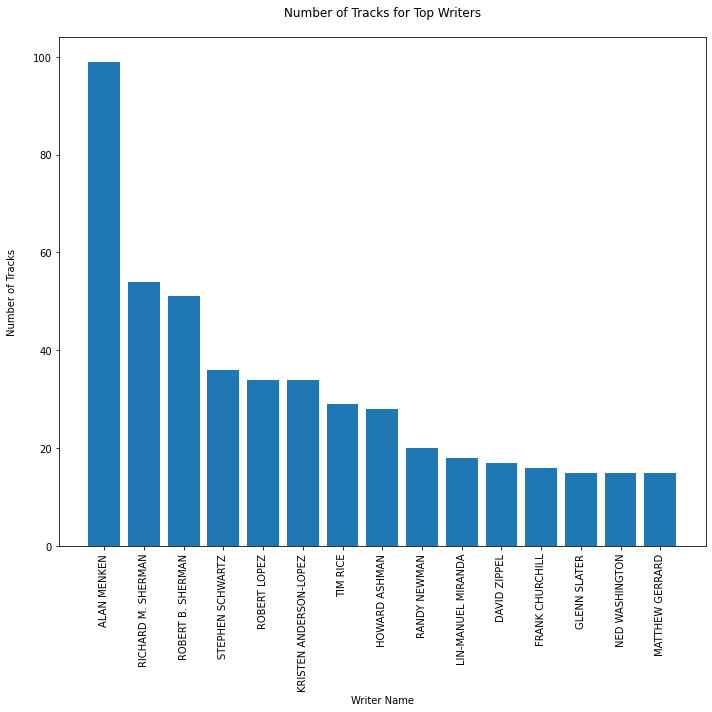

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.bar(top_writers['writer_name'], top_writers['songs_per_writer'])
plt.title("Number of Tracks for Top Writers\n")
plt.xlabel("Writer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Tracks\n")

plt.tight_layout()
plt.show()

In [179]:
#popular_performers
df = pd.DataFrame()
df['songs_per_performer'] = [len([songs['performer(s)'][i] for i in range(len(songs['performer(s)'])) if performer in songs['performer(s)'][i]]) for performer in unique_performers]
df['performer_name'] = unique_performers

df.head()

,songs_per_performer,performer_name
0,1,GEORGE GIVOT
1,2,SAMUEL E. WRIGHT
2,1,MARY KAY BERGMAN
3,1,BETTE MIDLER
4,1,BRUNO CAMPOS


In [180]:
top_performers = df.sort_values('songs_per_performer', ascending=False)[:15]
top_performers

,songs_per_performer,performer_name
509,47,CAST
447,46,CHORUS
7,20,DOVE CAMERON
430,16,ZAC EFRON
314,16,SOFIA CARSON
302,15,JIM CUMMINGS
381,14,VANESSA HUDGENS
286,14,IDINA MENZEL
158,12,OLIVIA RODRIGO
70,12,DICK VAN DYKE


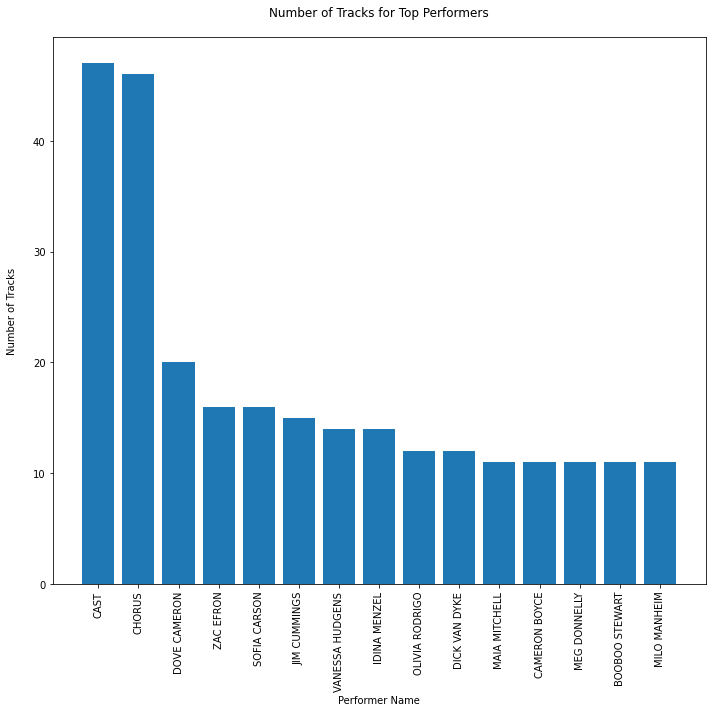

In [181]:
plt.figure(figsize=(10,10))

plt.bar(top_performers['performer_name'], top_performers['songs_per_performer'])
plt.title("Number of Tracks for Top Performers\n")
plt.xlabel("Performer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Tracks\n")

plt.tight_layout()
plt.show()

In [183]:
top_writer_names = list(top_writers['writer_name'])
top_writer_names

['ALAN MENKEN',
 'RICHARD M. SHERMAN',
 'ROBERT B. SHERMAN',
 'STEPHEN SCHWARTZ',
 'ROBERT LOPEZ',
 'KRISTEN ANDERSON-LOPEZ',
 'TIM RICE',
 'HOWARD ASHMAN',
 'RANDY NEWMAN',
 'LIN-MANUEL MIRANDA',
 'DAVID ZIPPEL',
 'FRANK CHURCHILL',
 'GLENN SLATER',
 'NED WASHINGTON',
 'MATTHEW GERRARD']

In [184]:
writer_stats = pd.DataFrame()

writer_stats['mean_num_verses'] = [np.mean([songs['num_verses'][i] for i in range(len(songs['writer(s)'])) if writer in songs['writer(s)'][i]]) for writer in top_writer_names]
writer_stats['mean_num_words'] = [np.mean([songs['num_words'][i] for i in range(len(songs['writer(s)'])) if writer in songs['writer(s)'][i]]) for writer in top_writer_names]
writer_stats['writer_name'] = top_writer_names

writer_stats

,mean_num_verses,mean_num_words,writer_name
0,35.979798,202.909091,ALAN MENKEN
1,27.407407,160.185185,RICHARD M. SHERMAN
2,28.078431,163.156863,ROBERT B. SHERMAN
3,38.305556,219.250000,STEPHEN SCHWARTZ
4,36.058824,230.676471,ROBERT LOPEZ
5,36.058824,230.676471,KRISTEN ANDERSON-LOPEZ
6,33.206897,194.241379,TIM RICE
7,41.607143,237.178571,HOWARD ASHMAN
8,33.950000,192.800000,RANDY NEWMAN
9,56.777778,323.277778,LIN-MANUEL MIRANDA


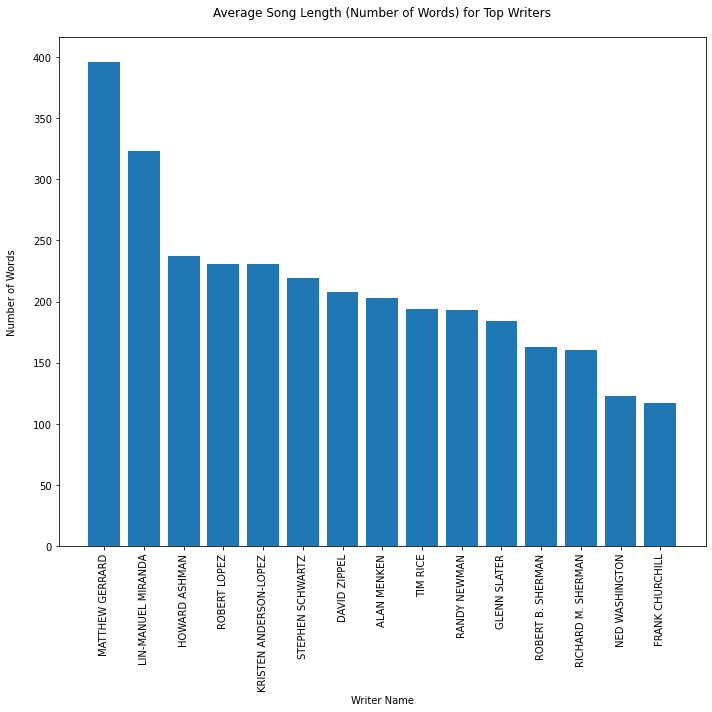

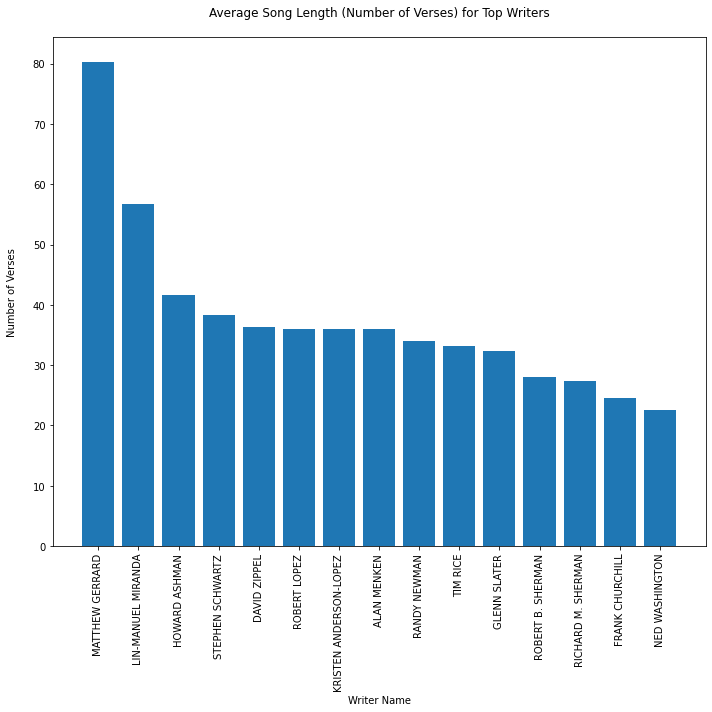

In [185]:
plt.figure(figsize=(10,10))

writer_stats = writer_stats.sort_values('mean_num_words',ascending=False)

plt.bar(writer_stats['writer_name'], writer_stats['mean_num_words'])
plt.title("Average Song Length (Number of Words) for Top Writers\n")
plt.xlabel("Writer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Words\n")

plt.tight_layout()
plt.show()

##############################################

plt.figure(figsize=(10,10))

writer_stats = writer_stats.sort_values('mean_num_verses',ascending=False)

plt.bar(writer_stats['writer_name'], writer_stats['mean_num_verses'])
plt.title("Average Song Length (Number of Verses) for Top Writers\n")
plt.xlabel("Writer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Verses\n")

plt.tight_layout()
plt.show()

In [187]:
top_performer_names = list(top_performers['performer_name'])
top_performer_names = top_performer_names[2:]  # drop cast and chorus performer names
top_performer_names

['DOVE CAMERON',
 'ZAC EFRON',
 'SOFIA CARSON',
 'JIM CUMMINGS',
 'VANESSA HUDGENS',
 'IDINA MENZEL',
 'OLIVIA RODRIGO',
 'DICK VAN DYKE',
 'MAIA MITCHELL',
 'CAMERON BOYCE',
 'MEG DONNELLY',
 'BOOBOO STEWART',
 'MILO MANHEIM']

In [188]:
performer_stats = pd.DataFrame()

performer_stats['mean_num_verses'] = [np.mean([songs['num_verses'][i] for i in range(len(songs['performer(s)'])) if performer in songs['performer(s)'][i]]) for performer in top_performer_names]
performer_stats['mean_num_words'] = [np.mean([songs['num_words'][i] for i in range(len(songs['performer(s)'])) if performer in songs['performer(s)'][i]]) for performer in top_performer_names]
performer_stats['performer_name'] = top_performer_names

performer_stats

,mean_num_verses,mean_num_words,performer_name
0,64.300000,379.800000,DOVE CAMERON
1,53.187500,304.937500,ZAC EFRON
2,68.437500,400.750000,SOFIA CARSON
3,29.066667,172.466667,JIM CUMMINGS
4,48.928571,276.571429,VANESSA HUDGENS
5,41.928571,260.214286,IDINA MENZEL
6,40.000000,254.250000,OLIVIA RODRIGO
7,35.166667,204.333333,DICK VAN DYKE
8,46.454545,295.636364,MAIA MITCHELL
9,72.090909,428.181818,CAMERON BOYCE


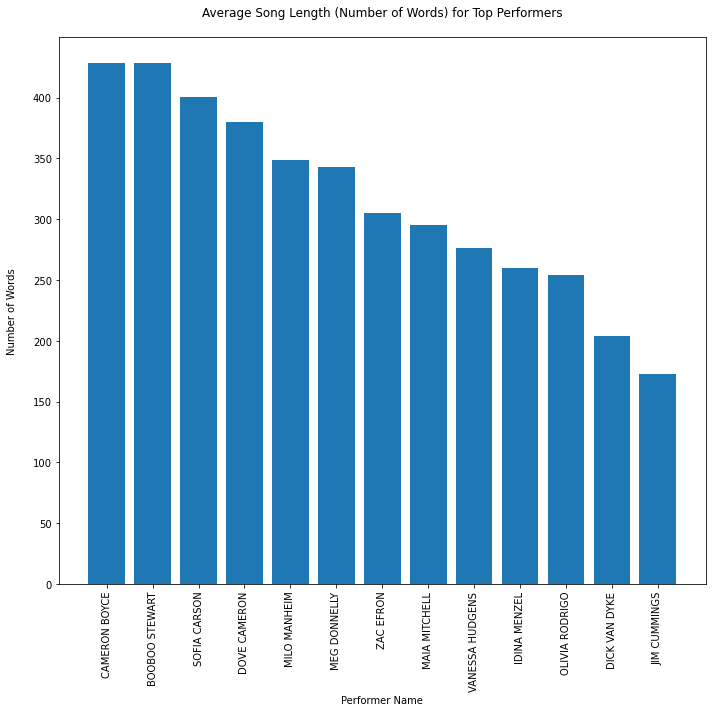

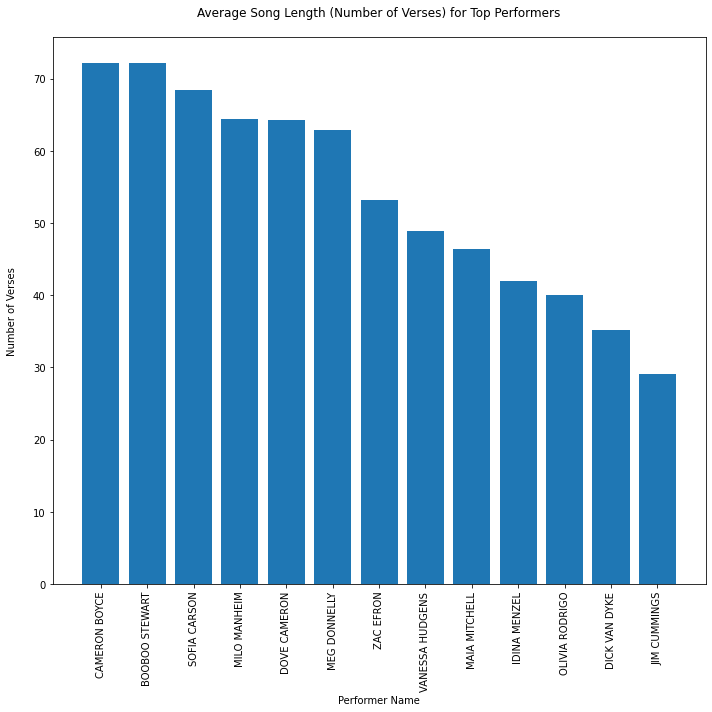

In [189]:
plt.figure(figsize=(10,10))

performer_stats = performer_stats.sort_values('mean_num_words',ascending=False)

plt.bar(performer_stats['performer_name'], performer_stats['mean_num_words'])
plt.title("Average Song Length (Number of Words) for Top Performers\n")
plt.xlabel("Performer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Words\n")

plt.tight_layout()
plt.show()


##############################3

plt.figure(figsize=(10,10))

performer_stats = performer_stats.sort_values('mean_num_verses',ascending=False)

plt.bar(performer_stats['performer_name'], performer_stats['mean_num_verses'])
plt.title("Average Song Length (Number of Verses) for Top Performers\n")
plt.xlabel("Performer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Verses\n")

plt.tight_layout()
plt.show()